1. Завантаження всіх бібліотек:


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


2. Завантаження та підготовка даних:

In [ ]:
import tensorflow as tf

# Завантажуємо CIFAR-10
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

train_images = train_images[(train_labels == 3) | (train_labels == 5)]
train_labels = train_labels[(train_labels == 3) | (train_labels == 5)]
test_images = test_images[(test_labels == 3) | (test_labels == 5)]
test_labels = test_labels[(test_labels == 3) | (test_labels == 5)]

train_labels[train_labels == 3] = 0
train_labels[train_labels == 5] = 1
test_labels[test_labels == 3] = 0
test_labels[test_labels == 5] = 1



3. Вибір та завантаження моделі MobileNetV2 з TensorFlow Hub:

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморожуємо всі шари базової моделі
base_model.trainable = False

# Додаємо власний повнозв'язаний шар
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # 1 вихід для бінарної класифікації
])

# Оглядаємо модель
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

4. Fine-Tuning:

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Завантаження базової моделі без верхнього шару
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Додаємо новий повнозв'язаний шар
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Для бінарної класифікації
])


train_images = tf.image.resize(train_images, (224, 224))
test_images = tf.image.resize(test_images, (224, 224))

# Розморожуємо верхні шари базової моделі
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Компілюємо модель
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Для бінарної класифікації
              metrics=['accuracy'])

# Тренуємо модель
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 221s 624ms/step - accuracy: 0.8043 - loss: 0.4115 - val_accuracy: 0.5000 - val_loss: 1.1564
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 191s 610ms/step - accuracy: 0.9489 - loss: 0.1429 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 182s 582ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.5000 - val_loss: 0.7449
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 634ms/step - accuracy: 0.9873 - loss: 0.0372 - val_accuracy: 0.5000 - val_loss: 1.9566
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 191s 610ms/step - accuracy: 0.9870 - loss: 0.0364 - val_accuracy: 0.5000 - val_loss: 1.6897
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 179s 570ms/step - accuracy: 0.9896 - loss: 0.0294 - val_accuracy: 0.5000 - val_loss: 0.8684
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 182s 581ms/step - accuracy: 0.9923 - loss: 0.0210 - val_accuracy: 0.5000 - val_loss: 5.0442
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.9955 -

5. Оцінка моделі (візуальна):

63/63 - 24s - 385ms/step - accuracy: 0.5000 - loss: 0.7422
Test accuracy: 0.5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step


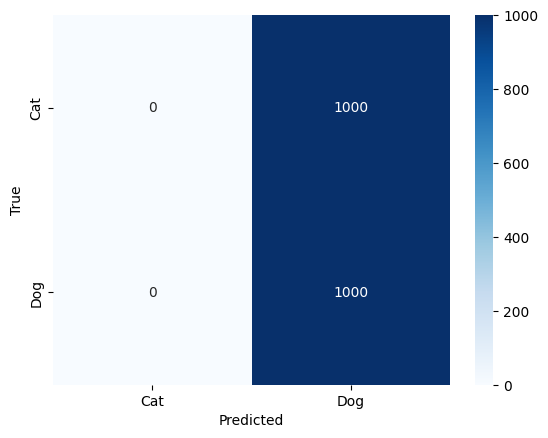

In [ ]:

test_images = tf.image.resize(test_images, (224, 224))

test_images = test_images / 255.0

# Оцінка точності
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

# Матриця похибок
predictions = model.predict(test_images)
predictions = (predictions > 0.5).astype(int)  # Бінарна класифікація

conf_matrix = confusion_matrix(test_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


6. Аналіз гіперпараметрів:

In [64]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=1, batch_size=16, validation_data=(test_images, test_labels))


625/625 ━━━━━━━━━━━━━━━━━━━━ 210s 305ms/step - accuracy: 0.9207 - loss: 0.2146 - val_accuracy: 0.5000 - val_loss: 4.3896
